# PINN pour un circuit RC-AC avec une perte physique 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

<u>Import nécessaire :</u>

In [39]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random


In [40]:
# Initialise random seed for model weights and activations

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)

In [41]:
# A  COMPLETER AVEC LE NOM DU FICHIER CSV
df = pd.read_csv( "rc_ac_results_12500L.csv" )
#print(df)
print( df.shape )

(75125, 12)


In [42]:

# Data normalisation
X = df[ [ "R" , "C" , "Vin" , "Frequency" ] ].values
#Y = df[ [ "Gain_basse", "Gain_haute" , "Phase_R" , "Phase_C" ] ].values
Y_GB = df[ [ "Gain_basse" ] ].values
Y_GH = df[ [ "Gain_haute" ] ].values
Y_PR = df[ [ "Phase_R" ] ].values
Y_PC = df[ [ "Phase_C" ] ].values


scaler_x = StandardScaler()
scaler_y_GB = StandardScaler()
scaler_y_GH = StandardScaler()
scaler_y_PR = StandardScaler()
scaler_y_PC = StandardScaler()

X_tensor = torch.tensor( scaler_x.fit_transform(X) , dtype = torch.float32 )
Y_tensor_GB = torch.tensor( scaler_y_GB.fit_transform(Y_GB) , dtype = torch.float32 )
Y_tensor_GH = torch.tensor( scaler_y_GH.fit_transform(Y_GH) , dtype = torch.float32 )
Y_tensor_PR = torch.tensor( scaler_y_PR.fit_transform(Y_PR) , dtype = torch.float32 )
Y_tensor_PC = torch.tensor( scaler_y_PC.fit_transform(Y_PC) , dtype = torch.float32 )

#print(X_tensor[:,0])
#print(Y_tensor)

dataset_GB = TensorDataset( X_tensor , Y_tensor_GB )
dataset_GH = TensorDataset( X_tensor , Y_tensor_GH )
dataset_PR = TensorDataset( X_tensor , Y_tensor_PR )
dataset_PC = TensorDataset( X_tensor , Y_tensor_PC )

#loader = DataLoader(dataset, batch_size=32, shuffle=True)

R = X_tensor[ :,0 ]
C = X_tensor[ :,1 ]
Frequency = X_tensor[ :,3 ]
print( R )
print( C )

print( ( R*C ).shape )

tensor([-1.0196, -1.0196, -1.0196,  ...,  1.7504,  1.7504,  1.7504])
tensor([-0.7601, -0.7601, -0.7601,  ...,  1.9125,  1.9125,  1.9125])
torch.Size([75125])


In [ ]:
class RegressionModel(nn.Module):
    def __init__( self , in_features , out_features = 1 ):
        super().__init__()

        """"
        nn.Linear( a , b ) crée une couche fully connected

            a : neurones en input
            b : neurones en output
        """
        self.fc1 = nn.Linear( in_features , 64 )
        self.fc2 = nn.Linear( 64 , 64 )
        self.fc3 = nn.Linear( 64 , 64 )
        self.fc4 = nn.Linear( 64 , 64 )
        self.fc5 = nn.Linear( 64 , 64 )
        self.fc6 = nn.Linear( 64 , out_features )
        


    def forward( self , x ):
        x = F.tanh( self.fc1( x ) )
        x = F.tanh( self.fc2( x ) )
        x = F.tanh( self.fc3( x ) )
        x = F.tanh( self.fc4( x ) )
        x = F.tanh( self.fc5( x ) )
        x = self.fc6( x )  # No activation on output for regression
        return x

In [44]:
in_features = 4
out_features = 1


model = RegressionModel( in_features , out_features )

criterion = nn.MSELoss()
optimizer = optim.Adam( model.parameters() , lr = 0.001 )


In [45]:
# Function to compute the PDE residual pour gain basse : 
""""
def pde_residual( model , x , out ):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_( True )
    u = model( x ).squeeze( )
    
    #t = x[ :, 0]
    # Compute the first derivative, du/dt.
    #u_x = ( torch.autograd.grad( u , t , grad_outputs = torch.ones_like(u) , create_graph = True )[ 0 ] )[ :,0 ]
    
    #print( u_x.shape )
    #print( x.shape )
    #print( u[:,0].shape )

    R = x[ :, 0 ]
    C = x[ :, 1 ]
    Vin = x[ :, 2 ]
    Frequency = x[ :, 3 ]
    w = 2 * torch.pi * Frequency

    # Sorties du modèle
    gain_basse_1 = u[ :, 0 ]
    gain_haute_1 = u[ :, 1 ]
    phase_R_1 = u[ :, 2 ]
    phase_C_1 = u[ :, 3 ]

    
    # Gain basse fréquence : 1 / sqrt(1 + (wRC)^2)
    gain_basse_th = 1 / torch.sqrt(1 + (w * R * C) ** 2)

    # Gain haute fréquence : 1 / sqrt(1 + (wRC)^2)
    gain_haute_th = 1 / torch.sqrt( 1 + ( w * R * C ) ** 2 )

    # Phase de R : arctan( wRC ) vers pi / 2
    phase_R_th = torch.atan( w * R * C )

    # Phase de C : -arctan(wRC) vers -pi / 2
    phase_C_th = - torch.atan( w * R * C )

    # Calculs des résidus
    res_gain_basse = ( gain_basse_1 - gain_basse_th ) ** 2
    res_gain_haute = ( gain_haute_1 - gain_haute_th ) ** 2
    res_phase_R = ( phase_R_1 - phase_R_th ) ** 2
    res_phase_C = ( phase_C_1 - phase_C_th ) ** 2

    #residual = res_gain_basse + res_gain_haute + res_phase_R + res_phase_C
    if out == "Gain_basse":
        residual = res_gain_basse
    elif out == "Gain_haute":
        residual = res_gain_haute
    elif out == "Phase_R":
        residual = res_phase_R
    elif out == "Phase_C":     
        residual = res_phase_C
    else:   
        print("Erreur : la sortie demandée n'est pas valide.")
        residual = None
    return torch.mean( residual )
"""

def pde_residual(model, x, out):
    x = x.clone().detach().requires_grad_(True)
    u = model(x).squeeze()  # Résultat : vecteur 1D (N,)

    R = x[:, 0]
    C = x[:, 1]
    Vin = x[:, 2]
    Frequency = x[:, 3]
    w = 2 * torch.pi * Frequency

    # Calcul de la cible physique selon le nom de sortie
    if out == "Gain_basse":
        u_phys = 1 / torch.sqrt(1 + (w * R * C) ** 2)
    elif out == "Gain_haute":
        u_phys = 1 / torch.sqrt(1 + (w * R * C) ** 2)
    elif out == "Phase_R":
        u_phys = torch.atan(w * R * C)
    elif out == "Phase_C":
        u_phys = -torch.atan(w * R * C)
    else:
        raise ValueError("Sortie non valide.")

    residual = (u - u_phys) ** 2
    return torch.mean(residual)


#pde_test = pde_residual(model, X_tensor)
#print(pde_test)
#print(pde_test.shape)



<u><b>GAIN BASSE</b></u>

Epoch [1], Loss: 1.290598631
Epoch [2], Loss: 1.289877534
Epoch [3], Loss: 1.289147258
Epoch [4], Loss: 1.288426042
Epoch [5], Loss: 1.287720323
Epoch [6], Loss: 1.287045717
Epoch [7], Loss: 1.286364555
Epoch [8], Loss: 1.285679340
Epoch [9], Loss: 1.284978986
Epoch [10], Loss: 1.284267545
Epoch [11], Loss: 1.283551693
Epoch [12], Loss: 1.282834649
Epoch [13], Loss: 1.282102585
Epoch [14], Loss: 1.281341553
Epoch [15], Loss: 1.280536890
Epoch [16], Loss: 1.279675841
Epoch [17], Loss: 1.278743148
Epoch [18], Loss: 1.277727246
Epoch [19], Loss: 1.276619196
Epoch [20], Loss: 1.275353909
Epoch [21], Loss: 1.273838162
Epoch [22], Loss: 1.272042632
Epoch [23], Loss: 1.270045877
Epoch [24], Loss: 1.267811418
Epoch [25], Loss: 1.265429497
Epoch [26], Loss: 1.263184547
Epoch [27], Loss: 1.260997653
Epoch [28], Loss: 1.258913517
Epoch [29], Loss: 1.256683469
Epoch [30], Loss: 1.254244685
Epoch [31], Loss: 1.251625657
Epoch [32], Loss: 1.248802304
Epoch [33], Loss: 1.245763540
Epoch [34], Loss: 1

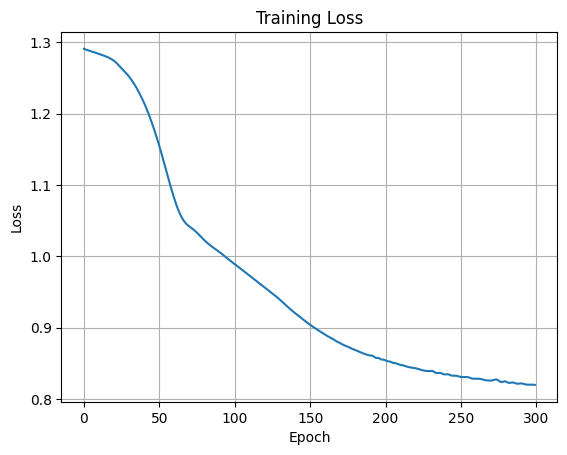

In [46]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
ld = 10
for i in range( nb_epochs ):
    """
        for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    """
    

    # Physics loss
    loss_physics_GB = pde_residual( model , X_tensor ,"Gain_basse")
    #loss_physics_GH = pde_residual( model , X_tensor ,"Gain_haute")
    #loss_physics_PR = pde_residual( model , X_tensor ,"Phase_R")
    #loss_physics_PC = pde_residual( model , X_tensor ,"Phase_C")

    # MSE loss
    outputs = model( X_tensor )
    
    loss_mse_GB = criterion( outputs , Y_tensor_GB )
    #loss_mse_GH = criterion( outputs , Y_tensor_GH )
    #loss_mse_PR = criterion( outputs , Y_tensor_PR )
    #loss_mse_PC = criterion( outputs , Y_tensor_PC )


    # final loss
    #loss = loss_mse + ld * loss_physics
    loss_GB = loss_mse_GB + loss_physics_GB
    #loss_GH = loss_mse_GH + loss_physics_GH
    #loss_PR = loss_mse_PR + loss_physics_PR
    #loss_PC = loss_mse_PC + loss_physics_PC

    optimizer.zero_grad()
    loss_GB.backward()
    #loss_GH.backward()
    #loss_PR.backward()
    #loss_PC.backward()
    optimizer.step()
    
    losses.append( loss_GB.item() )
    #losses.append( loss_GH.item() )
    #losses.append( loss_PR.item() )
    #losses.append( loss_PC.item() )



    print( f'Epoch [{i+ 1}], Loss: {loss_GB.item():.9f}' )

# Plot the loss curve
plt.plot( losses )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Training Loss' )
plt.grid( True )
plt.show()

   

<u><b>GAIN HAUSSE</b></u>

Epoch [1], Loss: 2.410972834
Epoch [2], Loss: 1.806432128
Epoch [3], Loss: 1.631775260
Epoch [4], Loss: 1.512501240
Epoch [5], Loss: 1.409310818
Epoch [6], Loss: 1.337725997
Epoch [7], Loss: 1.305211544
Epoch [8], Loss: 1.309194326
Epoch [9], Loss: 1.336197853
Epoch [10], Loss: 1.368402481
Epoch [11], Loss: 1.392046094
Epoch [12], Loss: 1.400015354
Epoch [13], Loss: 1.392112732
Epoch [14], Loss: 1.372323751
Epoch [15], Loss: 1.346051216
Epoch [16], Loss: 1.318733096
Epoch [17], Loss: 1.294658422
Epoch [18], Loss: 1.276653051
Epoch [19], Loss: 1.265869021
Epoch [20], Loss: 1.261530757
Epoch [21], Loss: 1.262904525
Epoch [22], Loss: 1.267137408
Epoch [23], Loss: 1.272078633
Epoch [24], Loss: 1.276030779
Epoch [25], Loss: 1.277918458
Epoch [26], Loss: 1.277358294
Epoch [27], Loss: 1.274572849
Epoch [28], Loss: 1.270202398
Epoch [29], Loss: 1.265036345
Epoch [30], Loss: 1.259846687
Epoch [31], Loss: 1.255251288
Epoch [32], Loss: 1.251658678
Epoch [33], Loss: 1.249206305
Epoch [34], Loss: 1

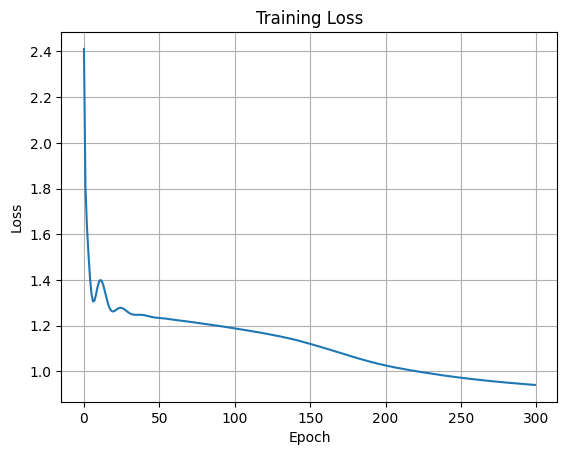

In [47]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
ld = 10
for i in range( nb_epochs ):
    """
        for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    """
    

    # Physics loss
    #loss_physics_GB = pde_residual( model , X_tensor ,"Gain_basse")
    loss_physics_GH = pde_residual( model , X_tensor ,"Gain_haute")
    #loss_physics_PR = pde_residual( model , X_tensor ,"Phase_R")
    #loss_physics_PC = pde_residual( model , X_tensor ,"Phase_C")

    # MSE loss
    outputs = model( X_tensor )
    
    #loss_mse_GB = criterion( outputs , Y_tensor_GB )
    loss_mse_GH = criterion( outputs , Y_tensor_GH )
    #loss_mse_PR = criterion( outputs , Y_tensor_PR )
    #loss_mse_PC = criterion( outputs , Y_tensor_PC )


    # final loss
    #loss = loss_mse + ld * loss_physics
    #loss_GB = loss_mse_GB + loss_physics_GB
    loss_GH = loss_mse_GH + loss_physics_GH
    #loss_PR = loss_mse_PR + loss_physics_PR
    #loss_PC = loss_mse_PC + loss_physics_PC

    optimizer.zero_grad()
    #loss_GB.backward()
    loss_GH.backward()
    #loss_PR.backward()
    #loss_PC.backward()
    optimizer.step()
    
    #losses.append( loss_GB.item() )
    losses.append( loss_GH.item() )
    #losses.append( loss_PR.item() )
    #losses.append( loss_PC.item() )



    print( f'Epoch [{i+ 1}], Loss: {loss_GH.item():.9f}' )

# Plot the loss curve
plt.plot( losses )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Training Loss' )
plt.grid( True )
plt.show()

   

<u><b>PHASE R</b></u>

Epoch [1], Loss: 2.911368608
Epoch [2], Loss: 2.718072891
Epoch [3], Loss: 2.458962440
Epoch [4], Loss: 2.199727774
Epoch [5], Loss: 2.013792992
Epoch [6], Loss: 1.943285704
Epoch [7], Loss: 1.961613536
Epoch [8], Loss: 2.021627665
Epoch [9], Loss: 2.068741798
Epoch [10], Loss: 2.071607590
Epoch [11], Loss: 2.030455828
Epoch [12], Loss: 1.964843988
Epoch [13], Loss: 1.898070455
Epoch [14], Loss: 1.846994877
Epoch [15], Loss: 1.818336964
Epoch [16], Loss: 1.809682369
Epoch [17], Loss: 1.812795401
Epoch [18], Loss: 1.818146229
Epoch [19], Loss: 1.818609476
Epoch [20], Loss: 1.811048746
Epoch [21], Loss: 1.796187878
Epoch [22], Loss: 1.777316093
Epoch [23], Loss: 1.758614779
Epoch [24], Loss: 1.743705153
Epoch [25], Loss: 1.734640956
Epoch [26], Loss: 1.731523514
Epoch [27], Loss: 1.732788682
Epoch [28], Loss: 1.735947490
Epoch [29], Loss: 1.738490343
Epoch [30], Loss: 1.738687515
Epoch [31], Loss: 1.735977054
Epoch [32], Loss: 1.730877399
Epoch [33], Loss: 1.724594593
Epoch [34], Loss: 1

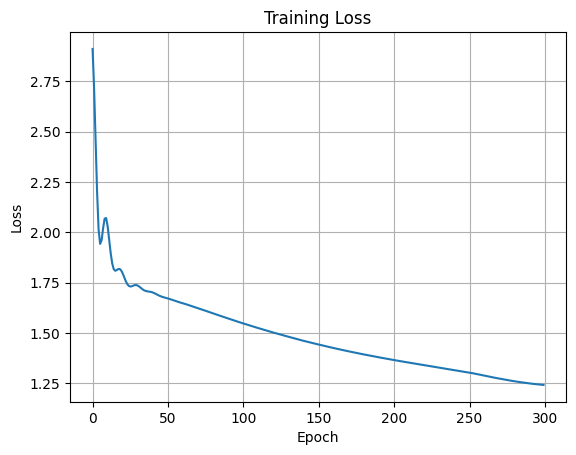

In [48]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
ld = 10
for i in range( nb_epochs ):
    """
        for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    """
    

    # Physics loss
    #loss_physics_GB = pde_residual( model , X_tensor ,"Gain_basse")
    #loss_physics_GH = pde_residual( model , X_tensor ,"Gain_haute")
    loss_physics_PR = pde_residual( model , X_tensor ,"Phase_R")
    #loss_physics_PC = pde_residual( model , X_tensor ,"Phase_C")

    # MSE loss
    outputs = model( X_tensor )
    
    #loss_mse_GB = criterion( outputs , Y_tensor_GB )
    #loss_mse_GH = criterion( outputs , Y_tensor_GH )
    loss_mse_PR = criterion( outputs , Y_tensor_PR )
    #loss_mse_PC = criterion( outputs , Y_tensor_PC )


    # final loss
    #loss = loss_mse + ld * loss_physics
    #loss_GB = loss_mse_GB + loss_physics_GB
    #loss_GH = loss_mse_GH + loss_physics_GH
    loss_PR = loss_mse_PR + loss_physics_PR
    #loss_PC = loss_mse_PC + loss_physics_PC

    optimizer.zero_grad()
    #loss_GB.backward()
    #loss_GH.backward()
    loss_PR.backward()
    #loss_PC.backward()
    optimizer.step()
    
    #losses.append( loss_GB.item() )
    #losses.append( loss_GH.item() )
    losses.append( loss_PR.item() )
    #losses.append( loss_PC.item() )



    print( f'Epoch [{i+ 1}], Loss: {loss_PR.item():.9f}' )

# Plot the loss curve
plt.plot( losses )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Training Loss' )
plt.grid( True )
plt.show()

   

<u><b>PHASE C</b></u>

Epoch [1], Loss: 2.469314814
Epoch [2], Loss: 2.392513990
Epoch [3], Loss: 2.267383575
Epoch [4], Loss: 2.113698959
Epoch [5], Loss: 1.951478362
Epoch [6], Loss: 1.804253101
Epoch [7], Loss: 1.679890752
Epoch [8], Loss: 1.582223654
Epoch [9], Loss: 1.508570552
Epoch [10], Loss: 1.455725670
Epoch [11], Loss: 1.419110298
Epoch [12], Loss: 1.392720938
Epoch [13], Loss: 1.372192860
Epoch [14], Loss: 1.356395960
Epoch [15], Loss: 1.343622923
Epoch [16], Loss: 1.333351254
Epoch [17], Loss: 1.324966908
Epoch [18], Loss: 1.317488194
Epoch [19], Loss: 1.310730696
Epoch [20], Loss: 1.304414511
Epoch [21], Loss: 1.298345327
Epoch [22], Loss: 1.292576075
Epoch [23], Loss: 1.287096500
Epoch [24], Loss: 1.282027006
Epoch [25], Loss: 1.277518511
Epoch [26], Loss: 1.273579359
Epoch [27], Loss: 1.270133018
Epoch [28], Loss: 1.267183304
Epoch [29], Loss: 1.264651418
Epoch [30], Loss: 1.262385368
Epoch [31], Loss: 1.260244966
Epoch [32], Loss: 1.258193731
Epoch [33], Loss: 1.256195784
Epoch [34], Loss: 1

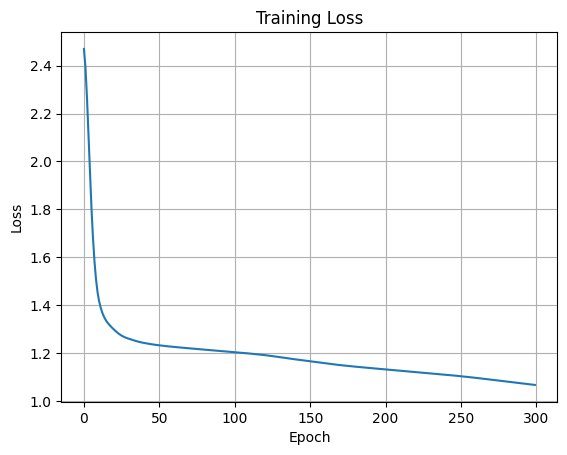

In [49]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
ld = 10
for i in range( nb_epochs ):
    """
        for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    """
    

    # Physics loss
    #loss_physics_GB = pde_residual( model , X_tensor ,"Gain_basse")
    #loss_physics_GH = pde_residual( model , X_tensor ,"Gain_haute")
    #loss_physics_PR = pde_residual( model , X_tensor ,"Phase_R")
    loss_physics_PC = pde_residual( model , X_tensor ,"Phase_C")

    # MSE loss
    outputs = model( X_tensor )
    
    #loss_mse_GB = criterion( outputs , Y_tensor_GB )
    #loss_mse_GH = criterion( outputs , Y_tensor_GH )
    #loss_mse_PR = criterion( outputs , Y_tensor_PR )
    loss_mse_PC = criterion( outputs , Y_tensor_PC )


    # final loss
    #loss = loss_mse + ld * loss_physics
    #loss_GB = loss_mse_GB + loss_physics_GB
    #loss_GH = loss_mse_GH + loss_physics_GH
    #loss_PR = loss_mse_PR + loss_physics_PR
    loss_PC = loss_mse_PC + loss_physics_PC

    optimizer.zero_grad()
    #loss_GB.backward()
    #loss_GH.backward()
    #loss_PR.backward()
    loss_PC.backward()
    optimizer.step()
    
    #losses.append( loss_GB.item() )
    #losses.append( loss_GH.item() )
    #losses.append( loss_PR.item() )
    losses.append( loss_PC.item() )



    print( f'Epoch [{i+ 1}], Loss: {loss_PC.item():.9f}' )

# Plot the loss curve
plt.plot( losses )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Training Loss' )
plt.grid( True )
plt.show()

   

GAIN BASSE :

Evaluation Loss: 0.600
Inverse Predictions: 
 [[1.0151945 ]
 [1.0151942 ]
 [1.0151939 ]
 ...
 [0.09269002]
 [0.09785149]
 [0.10313281]]


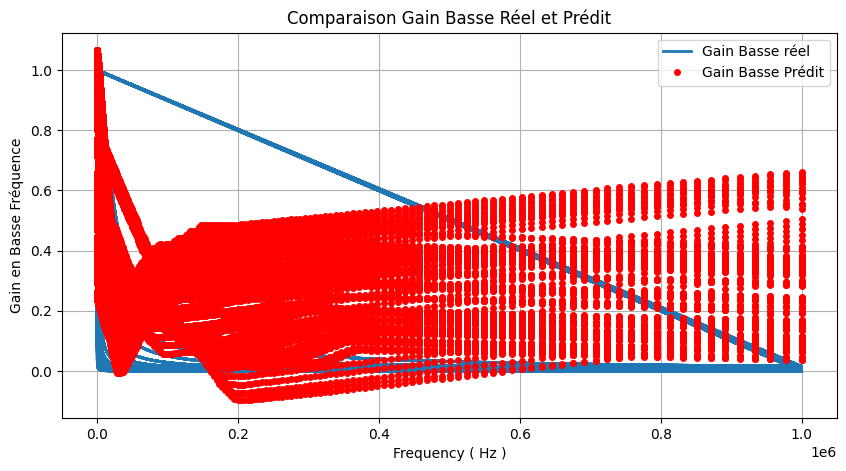

In [50]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model( X_tensor )  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_GB )
    print( f"Evaluation Loss: {loss.item():.3f}" )

    predictions_original = scaler_y_GB.inverse_transform( predictions.numpy() )

    # Print the inverse transformed predictions
    print( "Inverse Predictions: \n", predictions_original )


# Dénormalisation des prédictions et des vraies valeurs
predictions_original = scaler_y_GB.inverse_transform( predictions.numpy() )
Y_true_original = scaler_y_GB.inverse_transform( Y_tensor_GB.numpy() )

# Dénormalisation de la fréquence
frequencies = scaler_x.inverse_transform( X_tensor.numpy() )[:, 3]

# Tracé magnitude réelle vs prédite
plt.figure( figsize = ( 10 , 5 ) )
plt.plot( frequencies, Y_true_original[:, 0] , label = "Gain Basse réel" , linewidth = 2 )
plt.plot( frequencies, predictions_original[:, 0] , 'o' , label = "Gain Basse Prédit" , markersize = 4 , color='red' )

plt.xlabel("Frequency ( Hz )")
plt.ylabel("Gain en Basse Fréquence")
plt.title("Comparaison Gain Basse Réel et Prédit")

plt.legend()

plt.grid( True )

plt.show()


In [51]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[ param_tensor ].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 4])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([1, 8])
fc6.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [52]:
# Defining model name and save the model

name = "My_model_GB"    # À changer selon l'utilisateur
torch.save( model.state_dict() , name )

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_GB )
    #print( f"Evaluation Loss: {loss.item():.3f}" )

    print(f"Evaluation Loss after loading: {loss.item():.5f}")
    #print(f"Epoch {i+1}: total={loss.item():.5f}, mse={loss_mse.item():.5f}, phys={loss_physics.item():.5f}")


Evaluation Loss after loading: 0.60007


GAIN HAUSSE

Evaluation Loss: 2.092
Inverse Predictions: 
 [[1.1017299]
 [1.1017295]
 [1.1017293]
 ...
 [0.201205 ]
 [0.2062435]
 [0.211399 ]]


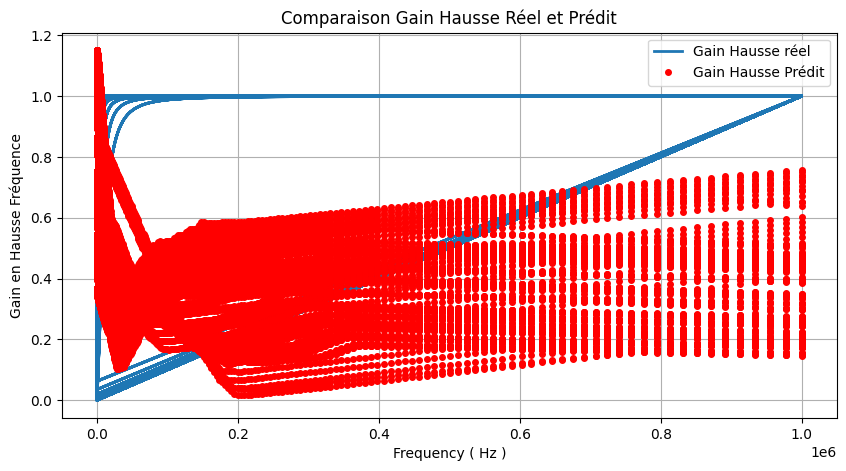

In [53]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model( X_tensor )  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_GH )
    print( f"Evaluation Loss: {loss.item():.3f}" )

    predictions_original = scaler_y_GH.inverse_transform( predictions.numpy() )

    # Print the inverse transformed predictions
    print( "Inverse Predictions: \n", predictions_original )


# Dénormalisation des prédictions et des vraies valeurs
predictions_original = scaler_y_GH.inverse_transform( predictions.numpy() )
Y_true_original = scaler_y_GH.inverse_transform( Y_tensor_GH.numpy() )

# Dénormalisation de la fréquence
frequencies = scaler_x.inverse_transform( X_tensor.numpy() )[:, 3]

# Tracé magnitude réelle vs prédite
plt.figure( figsize = ( 10 , 5 ) )
plt.plot( frequencies, Y_true_original[:, 0] , label = "Gain Hausse réel" , linewidth = 2 )
plt.plot( frequencies, predictions_original[:, 0] , 'o' , label = "Gain Hausse Prédit" , markersize = 4 , color='red' )

plt.xlabel("Frequency ( Hz )")
plt.ylabel("Gain en Hausse Fréquence")
plt.title("Comparaison Gain Hausse Réel et Prédit")

plt.legend()

plt.grid( True )

plt.show()


In [54]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[ param_tensor ].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 4])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([1, 8])
fc6.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [55]:
# Defining model name and save the model

name = "My_model_GH"    # À changer selon l'utilisateur
torch.save( model.state_dict() , name )

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_GH )
    #print( f"Evaluation Loss: {loss.item():.3f}" )

    print(f"Evaluation Loss after loading: {loss.item():.5f}")
    #print(f"Epoch {i+1}: total={loss.item():.5f}, mse={loss_mse.item():.5f}, phys={loss_physics.item():.5f}")


Evaluation Loss after loading: 2.09236


PHASE R

Evaluation Loss: 0.605
Inverse Predictions: 
 [[85.286896 ]
 [85.28686  ]
 [85.286835 ]
 ...
 [ 5.1449366]
 [ 5.593335 ]
 [ 6.052148 ]]


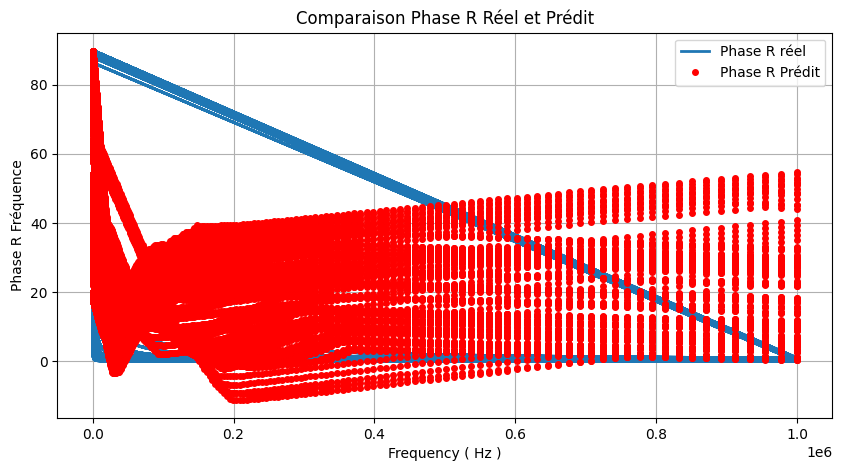

In [56]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model( X_tensor )  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_PR )
    print( f"Evaluation Loss: {loss.item():.3f}" )

    predictions_original = scaler_y_PR.inverse_transform( predictions.numpy() )

    # Print the inverse transformed predictions
    print( "Inverse Predictions: \n", predictions_original )


# Dénormalisation des prédictions et des vraies valeurs
predictions_original = scaler_y_PR.inverse_transform( predictions.numpy() )
Y_true_original = scaler_y_PR.inverse_transform( Y_tensor_PR.numpy() )

# Dénormalisation de la fréquence
frequencies = scaler_x.inverse_transform( X_tensor.numpy() )[:, 3]

# Tracé magnitude réelle vs prédite
plt.figure( figsize = ( 10 , 5 ) )
plt.plot( frequencies, Y_true_original[:, 0] , label = "Phase R réel" , linewidth = 2 )
plt.plot( frequencies, predictions_original[:, 0] , 'o' , label = "Phase R Prédit" , markersize = 4 , color='red' )

plt.xlabel("Frequency ( Hz )")
plt.ylabel("Phase R Fréquence")
plt.title("Comparaison Phase R Réel et Prédit")

plt.legend()

plt.grid( True )

plt.show()


In [57]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[ param_tensor ].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 4])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([1, 8])
fc6.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [58]:
# Defining model name and save the model

name = "My_model_PR"    # À changer selon l'utilisateur
torch.save( model.state_dict() , name )

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_PR )
    #print( f"Evaluation Loss: {loss.item():.3f}" )

    print(f"Evaluation Loss after loading: {loss.item():.5f}")
    #print(f"Epoch {i+1}: total={loss.item():.5f}, mse={loss_mse.item():.5f}, phys={loss_physics.item():.5f}")


Evaluation Loss after loading: 0.60498


Phase C

Evaluation Loss: 0.605
Inverse Predictions: 
 [[ -4.713107 ]
 [ -4.7131453]
 [ -4.7131643]
 ...
 [-84.855064 ]
 [-84.40666  ]
 [-83.94785  ]]


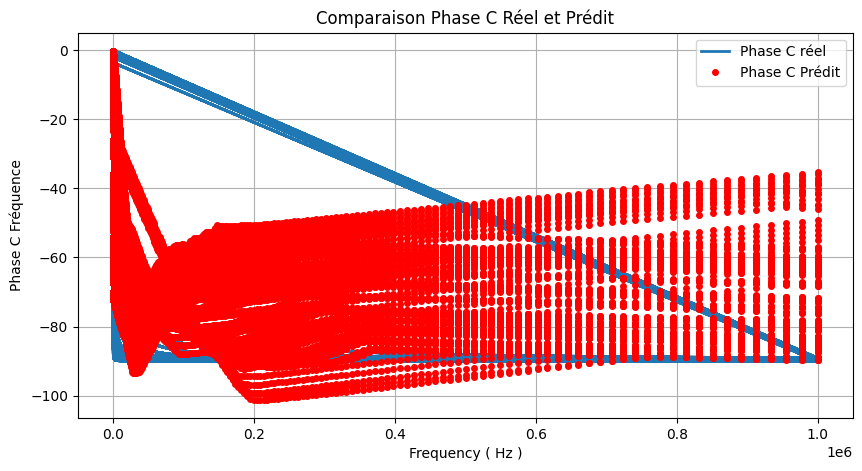

In [59]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model( X_tensor )  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_PC )
    print( f"Evaluation Loss: {loss.item():.3f}" )

    predictions_original = scaler_y_PC.inverse_transform( predictions.numpy() )

    # Print the inverse transformed predictions
    print( "Inverse Predictions: \n", predictions_original )


# Dénormalisation des prédictions et des vraies valeurs
predictions_original = scaler_y_PC.inverse_transform( predictions.numpy() )
Y_true_original = scaler_y_PC.inverse_transform( Y_tensor_PC.numpy() )

# Dénormalisation de la fréquence
frequencies = scaler_x.inverse_transform( X_tensor.numpy() )[:, 3]

# Tracé magnitude réelle vs prédite
plt.figure( figsize = ( 10 , 5 ) )
plt.plot( frequencies, Y_true_original[:, 0] , label = "Phase C réel" , linewidth = 2 )
plt.plot( frequencies, predictions_original[:, 0] , 'o' , label = "Phase C Prédit" , markersize = 4 , color='red' )

plt.xlabel("Frequency ( Hz )")
plt.ylabel("Phase C Fréquence")
plt.title("Comparaison Phase C Réel et Prédit")

plt.legend()

plt.grid( True )

plt.show()


In [60]:
# Print model's state_dict
print( "Model's state_dict:" )
for param_tensor in model.state_dict():
    print( param_tensor, "\t", model.state_dict()[ param_tensor ].size() )

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 4])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([1, 8])
fc6.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [61]:
# Defining model name and save the model

name = "My_model_PC"    # À changer selon l'utilisateur
torch.save( model.state_dict() , name )

# Load the saved model and evaluate

my_model = RegressionModel( in_features , out_features )
my_model.load_state_dict( torch.load( name , weights_only = True ) )
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model( X_tensor )  

    # Calculate the loss (optional)
    loss = criterion( predictions , Y_tensor_PC )
    #print( f"Evaluation Loss: {loss.item():.3f}" )

    print(f"Evaluation Loss after loading: {loss.item():.5f}")
    #print(f"Epoch {i+1}: total={loss.item():.5f}, mse={loss_mse.item():.5f}, phys={loss_physics.item():.5f}")


Evaluation Loss after loading: 0.60498


<u>Trier les données par fréquence et moyenner les prédictions pour chaque fréquence </u>

GB

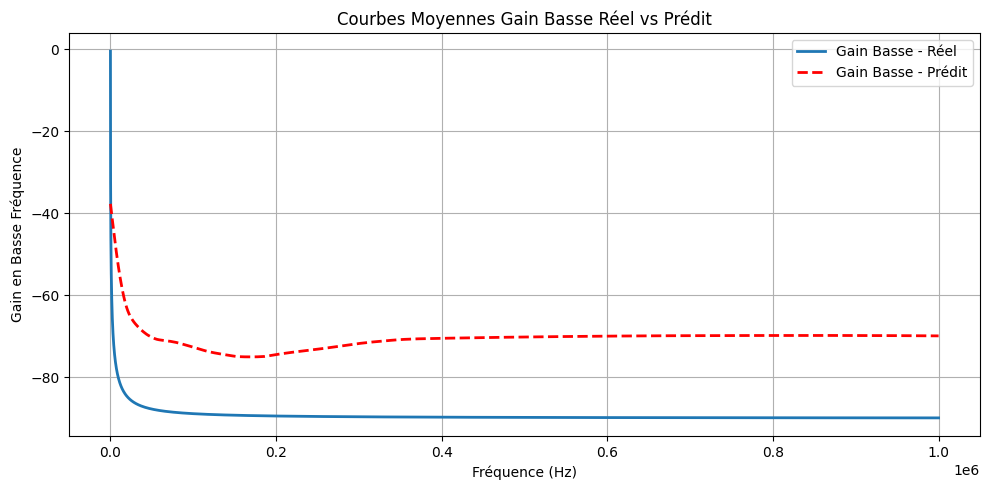

In [62]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
gain_basse_true = Y_true_original[:, 0]
gain_basse_pred = predictions_original[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Gain_basse_true": gain_basse_true,
    "Gain_basse_pred": gain_basse_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Gain_basse_true"], label="Gain Basse - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Gain_basse_pred"], label="Gain Basse - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain en Basse Fréquence")
plt.title("Courbes Moyennes Gain Basse Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


GH

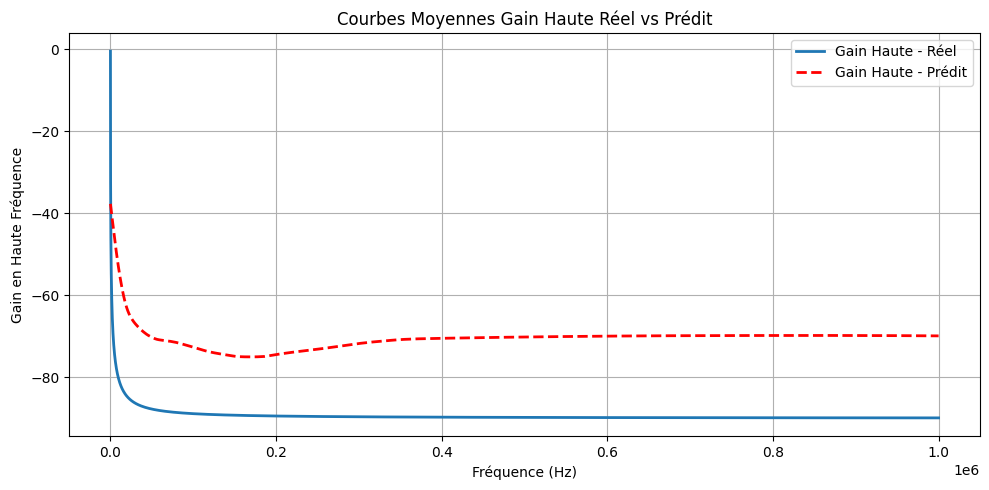

In [63]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
gain_haute_true = Y_true_original[:, 0]
gain_haute_pred = predictions_original[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Gain_haute_true": gain_haute_true,
    "Gain_haute_pred": gain_haute_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Gain_haute_true"], label="Gain Haute - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Gain_haute_pred"], label="Gain Haute - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain en Haute Fréquence")
plt.title("Courbes Moyennes Gain Haute Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PR

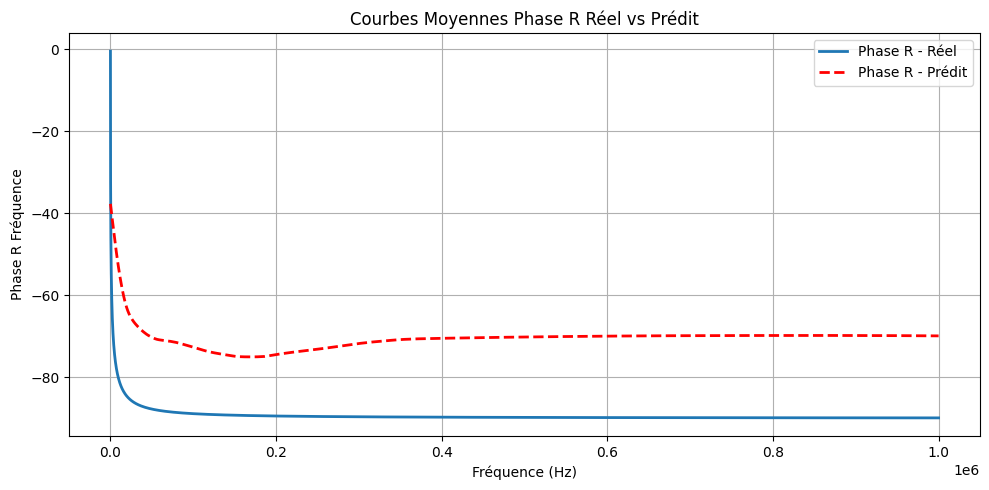

In [64]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
phase_r_true = Y_true_original[:, 0]
phase_r_pred = predictions_original[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Phase_r_true": phase_r_true,
    "Phase_r_pred": phase_r_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Phase_r_true"], label="Phase R - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Phase_r_pred"], label="Phase R - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase R Fréquence")
plt.title("Courbes Moyennes Phase R Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PC

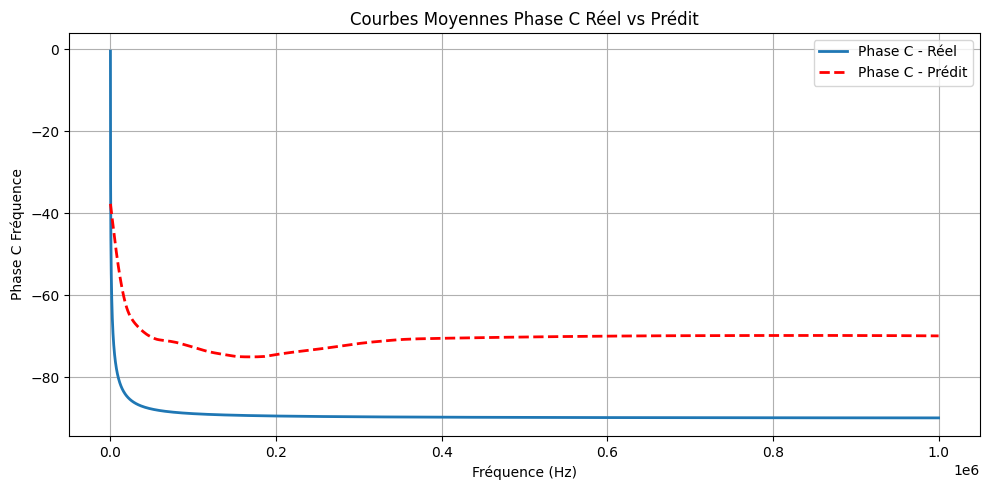

In [65]:
import pandas as pd

# Récupération des fréquences dénormalisées et des valeurs (réelles et prédites)
frequencies = scaler_x.inverse_transform(X_tensor.numpy())[:, 3]
phase_c_true = Y_true_original[:, 0]
phase_c_pred = predictions_original[:, 0]

# Créer un DataFrame pour regrouper et moyenner par fréquence
df_plot = pd.DataFrame({
    "Frequency": frequencies,
    "Phase_c_true": phase_c_true,
    "Phase_c_pred": phase_c_pred
})

# Regroupement par fréquence (moyenne pour chaque fréquence)
df_mean = df_plot.groupby("Frequency").mean().reset_index()

# Affichage de la courbe unique
plt.figure(figsize=(10, 5))
plt.plot(df_mean["Frequency"], df_mean["Phase_c_true"], label="Phase C - Réel", linewidth=2)
plt.plot(df_mean["Frequency"], df_mean["Phase_c_pred"], label="Phase C - Prédit", linewidth=2, linestyle='--', color='red')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Phase C Fréquence")
plt.title("Courbes Moyennes Phase C Réel vs Prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
